## Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# параметры отображения pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [28]:
# вспомогательная функция
def code_mean(data, cat_feature, real_feature):
    """возвращает значение нового признака на основе вещественного значения другого"""
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

## Задача 1:
- Проведите аналитику полученных данных 
- Подготовьте данные для регрессионной модели 
- Обучите регрессионную модель и осуществите прогноз на последний месяц для поля SALES 
- Оцените качество модели с помощью функции metric 

## Метрика для оценки Вашей модели

In [4]:
def metric(y_true, y_pred):    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

## Данные

In [5]:
df = pd.read_csv(r'.\data\data_regression_for_task.csv')

In [6]:
df.head(5)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.00,0.00
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.00,0.00
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.00,0.00
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.00,0.00
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.00,0.00


## Описание

- YEAR: год продажи 
- MONTH: месяц продажи 
- CONTRAGENT: поставщик товарной позиции 
- ARTICLE_CODE: код товарной позиции 
- ARTICLE_NAME: название товарной позиции 
- ARTICLE_GROUP: название группы товарных позиций 
- SALES: продажи товарной позиции в этот месяц и год (целевая переменная) 
- STORE_SALES: продажи всего магазина 


## аналитика полученных данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [8]:
df.describe(include=['int64','float64','object'])

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
count,128355.00,128355.00,128331,128355,128355,128354,128355.00,128355.00
unique,nan,nan,333,23556,23624,8,nan,nan
top,nan,nan,REPUBLIC NATIONAL DISTRIBUTING CO,23523,LA VIELLE FERME CDV RED - 750ML,WINE,nan,nan
freq,nan,nan,9847,10,19,79077,nan,nan
mean,2017.21,7.08,NaN,NaN,NaN,NaN,6563.04,22.62
std,0.40,3.65,NaN,NaN,NaN,NaN,28924.94,239.69
min,2017.00,1.00,NaN,NaN,NaN,NaN,-6490.00,-4996.00
25%,2017.00,5.00,NaN,NaN,NaN,NaN,0.00,0.00
50%,2017.00,8.00,NaN,NaN,NaN,NaN,330.00,1.00
75%,2017.00,10.00,NaN,NaN,NaN,NaN,3250.00,4.00


#### <font color='red'> В исходном датасете есть выбросы и шумы. Есть пропуски в данных. Далее нужно будет посмотреть распределение по каждому признаку</font>

### Ошибки в данных, которые виды из общего описания
- 1 Есть отрицательные цены в продажах и магазинах
- 2 Максимальные продажи, больше чем продажи магазина.
- 3 Есть дубли в названиях ARTICLE_NAME для одинаковых ARTICLE_CODE

In [9]:
df[['YEAR','MONTH']].drop_duplicates().sort_values(by=['YEAR','MONTH'])

,YEAR,MONTH
0,2017,4
2689,2017,5
18654,2017,6
19945,2017,8
41826,2017,9
2913,2017,10
72880,2017,11
3806,2017,12
101911,2018,1
4068,2018,2


### Подготовка данных

In [10]:
print('Начальное кол-во строк', df.shape[0])

Начальное кол-во строк 128355


In [11]:
# Вопрос к заказчику - Почему отрицательные цены? Можем убрать эти продажи?
df = df[df['SALES'] >= 0]
print('Убрали отрицательные продажи', df.shape[0])

df = df[df['STORE_SALES'] >= 0]
print('Убрали отрицательные продажи в магазинах', df.shape[0])

Убрали отрицательные продажи 128300
Убрали отрицательные продажи в магазинах 127994


### Визуальный анализ

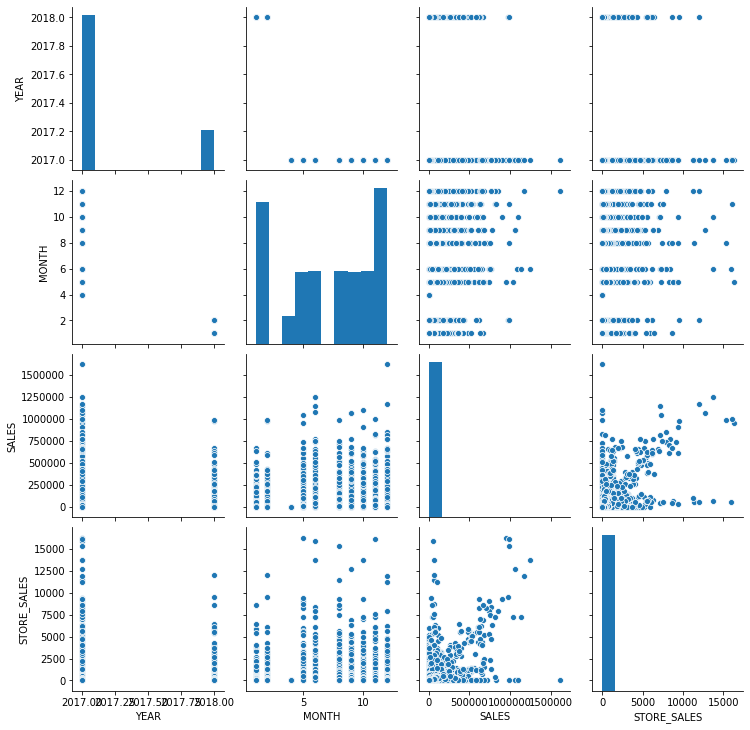

In [12]:
# построим парные диаграммы зависимости вещественных признаков
cols = df.select_dtypes(exclude=['object']).columns
sns.pairplot(df[cols])

### Выводы из парных графиков
- При нулевых продажах SALES, магазин может продавать другие позиции
- Есть сезонность продаж, по месяцам
- нет данных по июню 7-ому месяцу, в 2017 


In [ ]:
df

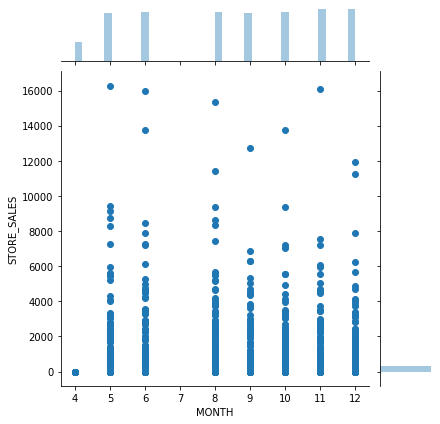

In [28]:
sns.jointplot(data=df[df['YEAR'] == 2017], x="MONTH", y="STORE_SALES")

### зависимость категориальных признаков 

Text(0.5, 1.0, 'Зависимость продаж от группы')

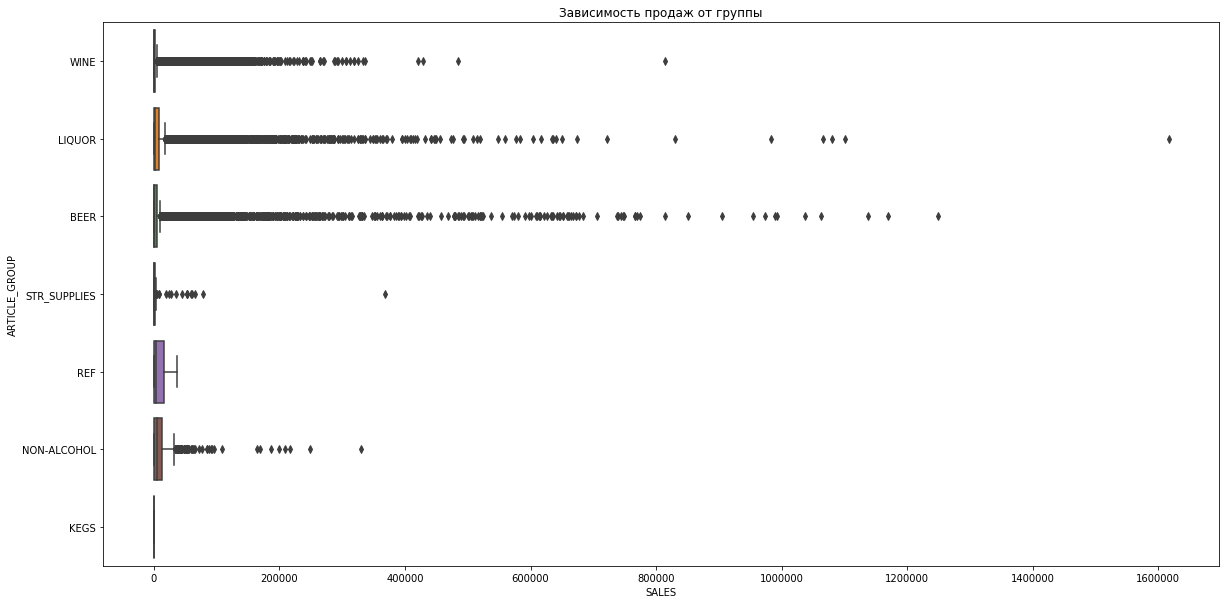

In [13]:
sns.boxplot(y='ARTICLE_GROUP', x='SALES', data=df, orient='h').set_title("Зависимость продаж от группы")

In [16]:
df.dropna(inplace=True)

In [23]:
df.head(3)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.00,0.00
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.00,0.00
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.00,0.00


In [32]:
# Переводим категориальные признаки ARTICLE_GROUP Группа товаров и CONTRAGENT контрагент в бинарные признаки. 1 да, 0 нет.
onehot_df = pd.get_dummies(df[['ARTICLE_GROUP','CONTRAGENT']])
df = pd.concat([df,onehot_df], axis = 1)

In [33]:
df.head(2)

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,ARTICLE_GROUP_BEER,ARTICLE_GROUP_KEGS,...,CONTRAGENT_WILLIAM GRANT AND SONS INC,CONTRAGENT_WILLIAM HARRISON IMPORTS,CONTRAGENT_WILLIAMS CORNER WINE,CONTRAGENT_WILSON DANIELS LTD,CONTRAGENT_WINE BRIDGE IMPORTS INC,CONTRAGENT_WINEBOW INC,CONTRAGENT_YOUNG WON TRADING INC,CONTRAGENT_YUENGLING BREWERY,CONTRAGENT_Z WINE GALLERY IMPORTS LLC,CONTRAGENT_ZURENA LLC
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.00,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.00,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Переводим признак кода товара (или наименование товара в вещественный признак, привязанный к средней цене товара)
# Если заполнять признаковую матрицу для каждого товара, то получается слишком большая матрица. Возможное решение - закодировать средней ценой товара. Новый признак будет упорядочивать товары по дороговизне 
df['ARTICLE_CODE_digitized'] = code_mean(df, 'ARTICLE_CODE' , 'SALES')

In [37]:
# удаляем object колонки
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127993 entries, 0 to 128352
Columns: 349 entries, YEAR to ARTICLE_CODE_digitized
dtypes: float64(3), int64(2), object(4), uint8(340)
memory usage: 51.3+ MB
